# Tree Search Demo

In [107]:
# your other imports here ...
import sys, os
import pandas as pd

# TODO: replace with your path/to/ninarow
ninarowdir = os.path.dirname(os.getcwd())
modelfitdir = ninarowdir + "/model_fitting/"
# os.listdir(modelfitdir)

# sets the import path to the model-fitting directory
sys.path.insert(0, modelfitdir)
from parsers import *
from model_fit import *
import model_fit

# WARNING: DO NOT USE %load_ext autoreload and %autoreload 2 may interfere with 
# the Multi-threading processes!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Handling

### File Formatting
The data columns should be ordered: 

    - black_pieces (binary), 
    - white_pieces (binary), 
    - player_color (Black/White), 
    - move (binary), 
    - response time (not used in fitting), 
    - [group_id] (optional), 
    - participant_id

for more info, see `parsers.py`

In [100]:
# TODO: make a folder (here I've called it "data/")
# which holds your data in a csv called data.csv and put its directory here ...
data_path = "../data"
data_csv = f"{data_path}/data.csv"
df = pd.read_csv(data_csv)[:10]
df.head()

,black,white,color,move,response_time,participant_id
0,16,0,White,4194304,1,1
1,16400,4194304,White,8388608,1,1
2,16793616,12582912,White,2097152,1,1
3,8192,0,White,4194304,1,1
4,2105344,4194304,White,16,1,1


We can show the boards using the `show` function from `utils`.

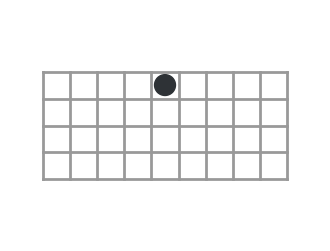

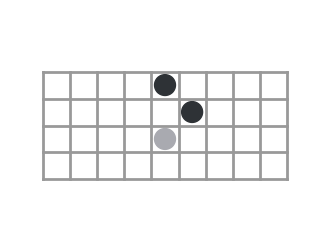

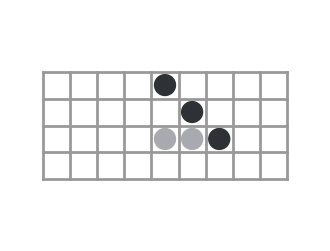

In [106]:
from utils import show

for row in df.head(3).itertuples(): 
    show(row.black, row.white)

## Creating Cross Validation Splits

We can easily create cross validation splits by using `utils.make_splits`, which takes in a dataframe
and outputs into a specified `data_path`

In [ ]:
from utils import make_splits
splits = make_splits(df, output_dir = data_path)

# view the first few lines of the first split
splits[0].head()

Saving split1 to ../data/1.csv
Saving split2 to ../data/2.csv
Saving split3 to ../data/3.csv
Saving split4 to ../data/4.csv
Saving split5 to ../data/5.csv


,black,white,color,move,response_time,participant_id
0,16400,4194304,White,8388608,1,1
1,2684354560,4194304,White,2097152,1,1


The parser takes in a CSV filename and turns it into a list of 
objects of type CSVMove ...

# Fitting the Model to Data

In [60]:
data_path = "../data"
output_path = "../data/out"
n_splits = 5
fold_number = 1
threads = 1
random_sample = False
verbose = True

print(f"Building output directory at {output_path}")
os.makedirs(output_path, exist_ok = True)

Building output directory at ../data/out


## Part 1: Loading Data

In [ ]:
# first, we have to check to see if all the splits are there ...
assert np.all([f"{i + 1}.csv" in os.listdir(data_path) for i in range(n_splits)])
print("Detected splits in this directory. Loading splits ...")

# then we read them in
splits = [pd.read_csv(f"{data_path}/{i + 1}.csv") for i in range(n_splits)]

# we convert every row of our CSV to a "CSVMove object" using df_to_CSVMove - we do so for all the splits
# CSVMove is a class that is defined in the parsers.py file 
fold_data = [[csvmove for csvmove in df_to_CSVMove(split, warn = False)] for split in splits]

Detected splits in this directory. Loading splits ...
Building output directory at ../data/out


## Part 2: Model Fitting

To ensure that the code is perfectly reproducible, we use a **single thread** and we set the manual seed to a number of our choosing. If we use multiple threads, the code will still work but the operating system may choose the order of the threads arbitrarily, leading to variation in the output.

You should see an output that looks something like: 

    Setting manual seed 10 for single-thread
    Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203

Note that if you run this code multiple times, the Random Number should be the same. This means our thread will be initialized with a particular random seed - as it runs, it will not be reinitialized, so the randomness will still proceed, but in a predictable way.

In [51]:
from multiprocessing import Pool, Value, set_start_method
random.seed(10)
initialize_thread_pool(1, manual_seed = 10)

Setting manual seed 10 for single-thread
Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203



We are now ready to begin running our model. We will begin with the default model and then feed it to our  `ModelFitter` class. Note that this code may take a very long time to run (a couple hours)...

In [52]:
model = DefaultModel()
model_fitter = ModelFitter(model, 
                           random_sample = random_sample, 
                           verbose = verbose, 
                           threads = threads)

params, loglik_train, loglik_test = model_fitter.cross_validate(fold_data, fold_number - 1)

Cross validating split 1 against the other 4 splits
[Preprocessing] Initial log-likelihood estimation


 10%|█         | 1/10 [00:01<00:12,  1.43s/it]


KeyboardInterrupt: 

We can examine the fitted model parameters below ...

In [84]:
loglik_train_df = pd.DataFrame(loglik_train, columns = ["loglik_train"])
loglik_test_df = pd.DataFrame(loglik_test, columns = ["loglik_test"])

print("Fitted Model Parameters")
param_df = pd.DataFrame(dict(zip(model_fitter.model.param_names, params), index = [0])).drop("index", axis = 1)
param_df

Fitted Model Parameters


,Stopping threshold,Pruning threshold,Gamma,Lapse rate,Opponent scale,Exploration constant,Center weight,FP C_act,FP C_pass,FP delta
0,1.143486,0.011378,0.237918,0.053329,1.304252,1.829346,0.435217,-0.667626,4.117251,5.289307


## Part 3: Saving Parameters

We will save the log likelihood for the train and test folds, as well as the parameters, as `{fold_number}_lltrain.csv`, `{fold_number}_lltest.csv`, and `{fold_number}_params.csv` in the directory specified by `{output_path}`

In [85]:
loglik_train_df.to_csv(f"{output_path}/{fold_number}_lltrain.csv", index = False)
loglik_test_df.to_csv(f"{output_path}/{fold_number}_lltest.csv", index = False)
param_df.to_csv(f"{output_path}/{fold_number}_params.csv", index = False)

# Running an Existing Model

Let's start by taking an arbitrary board state and run our model prediction on it ...

(<Figure size 400x300 with 1 Axes>, <Axes: >)

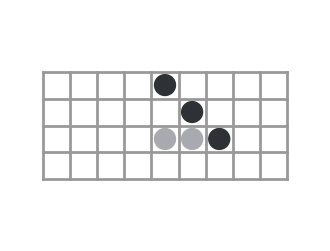

In [109]:
black = 16793616	
white = 12582912
show(black, white)

In [87]:
param_path = f"{output_path}/{fold_number}_params.csv"
param_df = pd.read_csv(param_path)

In [90]:
params = param_df.iloc[0].values

In [91]:
model = DefaultModel()
heuristic = model.create_heuristic(params)

